In [20]:
import inspect
import json
import os
import time
import numpy as np
from functools import wraps
import pandas as pd
import seaborn as sns
import random
import tempfile
import pathlib
import zstandard as zstd
import abc

Platform class

In [32]:


class Platform:
    def __init__(self, algorithm, processing, table_path):
        self.algorithm = algorithm
        self.processing = processing
        self.table_path = table_path
        self.logs = False


        self.benchmark = {"name" : type(self.algorithm).__name__, "table_path": table_path}

    def start(self, run_type="test", logs=False):
        self.logs = logs

        if self.logs:
            if isinstance(self.algorithm, LosslessCompressionAlgorithm):
                self.benchmark["isLossLess"] = True
            else:
                self.benchmark["isLossLess"] = False

            if isinstance(self.algorithm, LearningCompressionAlgorithm):
                self.benchmark["isLearning"] = True
            else:
                self.benchmark["isLearning"] = False

        if run_type == 'test':
            self.test()
        elif run_type == 'compress':
            self.preprocess_and_compress()
        elif run_type == 'decompress':
            self.decompress_and_postprocess()

    def measure_time(flag):
        def decorator(func):
            def wrapper(self, *args, **kwargs):
                start_time = time.time()
                result = func(self, *args, **kwargs)
                end_time = time.time()

                if getattr(self, flag):
                    print(f"Function {func.__name__} took {end_time - start_time} seconds to execute.")
                    self.benchmark[func.__name__ + "_time"] = end_time - start_time

                return result
            return wrapper
        return decorator

    def get_names(self):
        return {"compressed": self.table_path + "_compressed",
                 "decompressed": self.table_path + "_decompressed",
                 "preprocessed": self.table_path + "_preprocessed"}


    @measure_time("logs")
    def preprocess_and_compress(self):
        names = self.get_names()

        table_file = open(self.table_path, 'rb')
        preprocessed_file = open(names["preprocessed"], 'w+b')
        self.processing.do_preprocess(table_file, preprocessed_file)
        table_file.close()

        compressed_file = open(names["compressed"], 'wb')
        self.algorithm.compress(preprocessed_file, compressed_file)
        preprocessed_file.close()

        if self.logs:

            table_file = open(self.table_path, 'rb')

            compression_rate = self.get_compression_rate(table_file, compressed_file)

            compressed_file.close()
            table_file.close()


            self.benchmark["compression_rate"] = compression_rate
        return 0

    @measure_time("logs")
    def decompress_and_postprocess(self):
        names = self.get_names()

        compressed_file = open(names["compressed"], 'a+b')
        decompressed_file = open(names['decompressed'], 'wb')

        self.algorithm.decompress(compressed_file, decompressed_file)
        compressed_file.close()

        self.processing.do_postprocess(decompressed_file)

        if self.logs:
            profile_file = open(self.table_path, 'rb')
            loss_rate = self.get_loss_rate(profile_file, decompressed_file)
            profile_file.close()
            self.benchmark["loss_rate"] = loss_rate

        return 0

    @measure_time("logs")
    def test(self):
        self.preprocess_and_compress()
        self.decompress_and_postprocess()
        return 0 #TODO: result codes

    def get_compression_rate(self, input_file, compressed_file): #I'm assuming compressed_table is actually bytes-like

        print(compressed_file.name)
        input_file.seek(0, os.SEEK_END)
        compressed_file.seek(0, os.SEEK_END)
        print(input_file.tell())
        print(compressed_file.tell())
        return compressed_file.tell() / input_file.tell()

    def get_loss_rate(self, input_file, decompressed_file):
        print("I am dummy: ", inspect.currentframe().f_code.co_name)
        return random.randint(0, 20)



In [33]:
def json_platform(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)

    platform = Platform(globals()[config["Algorithm"]](), globals()[config["Processing"]](), config["table_path"])
    platform.start(config["run_type"], config["logs"])

json_platform("plug_config.json")

b''
I am dummy compression
flush.txt_compressed
12
12
Function preprocess_and_compress took 0.001995086669921875 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 1.005162000656128 seconds to execute.
Function test took 1.0071570873260498 seconds to execute.


Compression Algorithm Classes

In [34]:
import abc

class CompressionAlgorithm(abc.ABC):
    def __init__(self):
        ...
    @property
    @abc.abstractmethod
    def name(self):
        ...

    @abc.abstractmethod
    def compress(self, table_file, compressed_file):
        ...

    @abc.abstractmethod
    def decompress(self, compressed_file, decompressed_file):
        ...

class LearningCompressionAlgorithm(CompressionAlgorithm):

    @abc.abstractmethod
    def fit(self, training_data):
        ...

class NonLearningCompressionAlgorithm(CompressionAlgorithm):
    ...

class LosslessCompressionAlgorithm(CompressionAlgorithm):
    ...

class LossyCompressionAlgorithm(CompressionAlgorithm):
    ...

In [35]:
class DummyCompressionAlgorithm(LosslessCompressionAlgorithm, NonLearningCompressionAlgorithm):
    name = 'Dummy Compression Algorithm'
    def compress(self, table_file, compressed_file):
        table_file.seek(0)
        compressed_file.seek(0)
        compressed_file.write(table_file.read())
        print(table_file.read())
        print("I am dummy compression")
        return 0 # TODO: status codes
    def decompress(self, compressed_file, decompressed_file):
        compressed_file.seek(0)
        decompressed_file.seek(0)
        decompressed_file.write(compressed_file.read())
        time.sleep(1)
        print("I am dummy decompression")
        return 0 # TODO: status codes

In [36]:
class ZstdLibraryCompressionAlgorithm(LosslessCompressionAlgorithm, NonLearningCompressionAlgorithm):
    name = 'zstd library'
    def compress(self, table_file, compressed_file):
        compressor = zstd.ZstdCompressor(level=22)
        compressor.copy_stream(table_file, compressed_file)
        return 0
    def decompress(self, compressed_file, decompressed_file):
        decompressor = zstd.ZstdDecompressor()
        decompressor.copy_stream(compressed_file,decompressed_file)
        return 0

Processing Classes

In [37]:
class Processing(abc.ABC):
    def __init__(self):
        ...
    @property
    @abc.abstractmethod
    def name(self):
        ...

    @abc.abstractmethod
    def do_preprocess(self, raw_file, processed_file):
        ...

    @abc.abstractmethod
    def do_postprocess(self, processed_file):
        ...

In [38]:
class DummyProcessing(Processing):
    name = "Dummy Pre/Post-Processing"
    def do_preprocess(self, raw_file, processed_file):
        raw_file.seek(0)
        processed_file.seek(0)
        processed_file.write(raw_file.read())
        return 0 # TODO: replace with enum / status codes
    def do_postprocess(self, processed_file):
        return 0 # TODO: replace with enum/status codes


Testing

In [39]:
benchmarks = []
Algos = [DummyCompressionAlgorithm(), ZstdLibraryCompressionAlgorithm()]
Processes = [DummyProcessing()]
for algo in Algos:
    for proc in Processes:
        a = Platform(algo, proc, "flush.txt")
        a.start("test", logs=True)
        print(a.benchmark)
        benchmarks.append(a.benchmark)
        print("---------------------")

b''
I am dummy compression
flush.txt_compressed
12
12
Function preprocess_and_compress took 0.014960050582885742 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 1.017477035522461 seconds to execute.
Function test took 1.0324370861053467 seconds to execute.
{'name': 'DummyCompressionAlgorithm', 'table_path': 'flush.txt', 'isLossLess': True, 'isLearning': False, 'compression_rate': 1.0, 'preprocess_and_compress_time': 0.014960050582885742, 'loss_rate': 16, 'decompress_and_postprocess_time': 1.017477035522461, 'test_time': 1.0324370861053467}
---------------------
flush.txt_compressed
12
9
Function preprocess_and_compress took 0.000993967056274414 seconds to execute.
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 0.0009970664978027344 seconds to execute.
Function test took 0.002989053726196289 seconds to execute.
{'name': 'ZstdLibraryCompressionAlgorithm', 'table_path': 'flush.txt', 'isLossLess': True, '

In [31]:
#1. replace json with arguments of the class | DONE
#2. do not keep table in class instance | DONE
#3. change names of the Platform to more relevant | DONE
#4. rename compression to compress | DONE
#5. add ability to not compress tables every time Platform being created | I can just pass already preprocessed table to Platform
#and also pass the flush preprocessing class which do nothing

In [15]:
import matplotlib.pyplot as plt

def plot_graphics(n_values):
    plt.bar(range(len(n_values)), n_values)
    plt.title('Comparison of n Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()


In [16]:
def plot_benchmarks(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.barplot(x='index', y=column_name, data=df)

def plot_scatter(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.scatterplot(x='index', y=column_name, data=df)

def plot_hist(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.histplot(x='index', y=column_name, data=df)



9
7
12
7
13
12


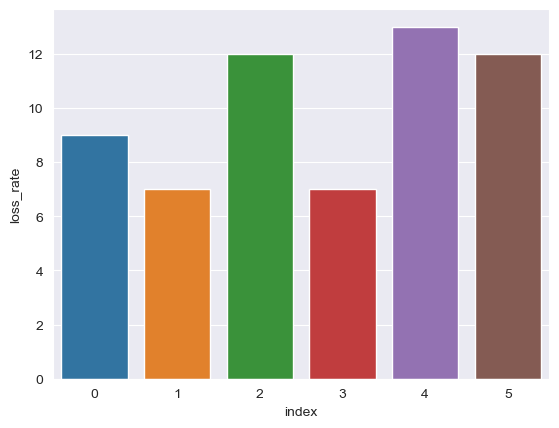

In [17]:
plot_benchmarks(benchmarks, "loss_rate")
for i in benchmarks:
    print(i["loss_rate"])

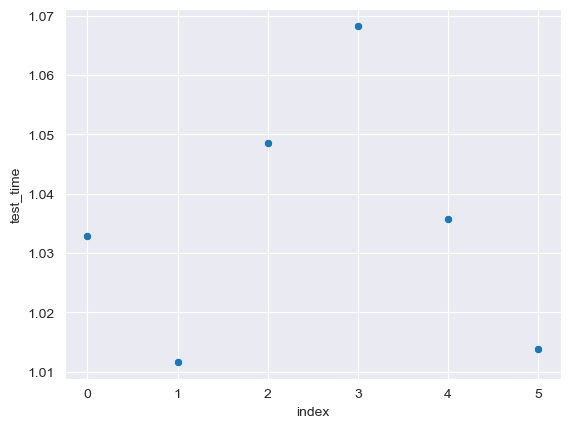

In [18]:
plot_scatter(benchmarks, "test_time")

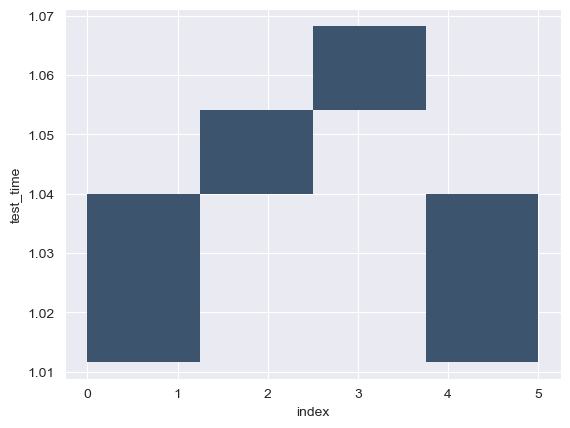

In [19]:
plot_hist(benchmarks, "test_time")